In [51]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

(5, 693)
[ 95.73505447 246.2         16.8         13.          14.        ]
(35, 4, 1000)


(0.0, 100.0)

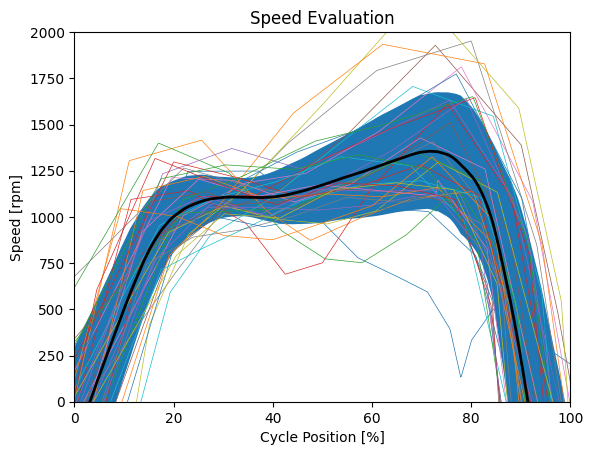

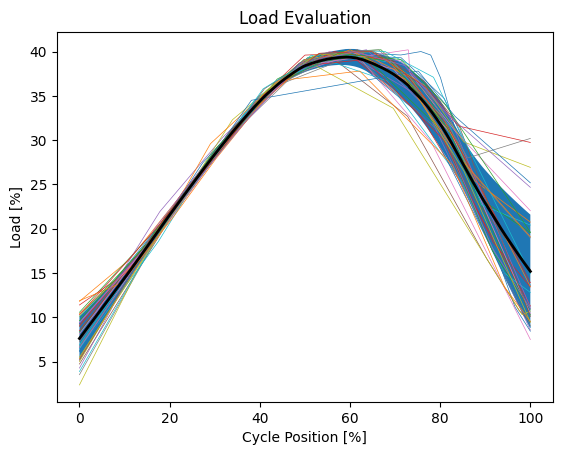

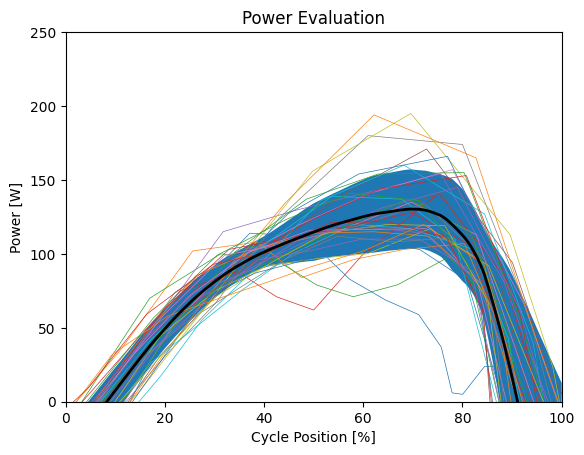

In [94]:
data = np.genfromtxt(
    'Training.txt',          # Replace 'data.txt' with the path to your file
    delimiter=';',       # Delimiter used in the file
    dtype=None,          # Automatically infer data types for each column
    names=True,          # Use the first row as column names
    encoding='utf-8'     # Set encoding to read text data correctly
)

timestamps = data['TIMESTAMP']
position = np.array(data['POSITION'], dtype=float)
speed = np.array(data['SPEED'], dtype=float)
load = np.array(data['LOAD'],dtype=float)
power = np.array(data['POWER'])
torque_ref = np.array(data['TORQUEREF'])

values = [position, speed, load, power, torque_ref]




min = np.min(position)
max = np.max(position)

dp = max-min
relative_position = (position - np.ones(np.shape(position)) * min) / dp * 100

values = [relative_position, speed, load, power, torque_ref]
values = np.stack(values)
print(np.shape(values))
print(values[:,1])
x_common = np.linspace(0, 100, 1000)


last_cycle = []
last_speeds_cache = []
processed = False

cycles = []
def evaluateValue(measurement_values: np.ndarray):
    global processed
    global last_cycle
    global last_speeds_cache
    global cycles
    global x_common
    if (len(last_speeds_cache)>=3):
        last_speeds_cache.pop(0)
    
    last_speeds_cache.append(measurement_values[1])

    if measurement_values[1] <= 0:
        last_cycle.append(measurement_values)
        processed = False
        return
    

    if not processed and len(last_speeds_cache)==3:
        if  all([ v > 0 for v in last_speeds_cache ]) :
            # print("Processing")
            if len(last_cycle) > 0:
                vals = np.stack(last_cycle).T
                interpolator = interp1d(vals[0,:], vals[1,:], kind='linear', fill_value="extrapolate")
                speed_interpolated = interpolator(x_common)

                interpolator = interp1d(vals[0,:], vals[2,:], kind='linear', fill_value="extrapolate")
                load_interpolated = interpolator(x_common)



                interpolator = interp1d(vals[0,:], vals[3,:], kind='linear', fill_value="extrapolate")
                power_interpolated = interpolator(x_common)


                cycles.append(np.stack([x_common, -1 * speed_interpolated, load_interpolated, -1 *power_interpolated]))
            # 
            # pass
            last_cycle.clear()
            processed = True


for i in range(np.shape(values)[1]):
    evaluateValue(values[:,i])


print(np.shape(cycles))

cycles = np.stack(cycles)
mean = np.mean(cycles, axis=0)
stddev = np.std(cycles, axis=0)


lower = mean[1] - stddev[1]
upper = mean[1] + stddev[1]

plt.figure()
plt.title("Speed Evaluation")
plt.ylabel("Speed [rpm]")
plt.xlabel("Cycle Position [%]")
plt.fill_between(mean[0], upper, lower, where=(lower<upper))
for cycle in cycles:
    plt.plot(cycle[0], cycle[1], linewidth=0.5)
plt.plot(mean[0], mean[1], linewidth=2, color="black")
plt.ylim([0, 2000])
plt.xlim([0, 100])



lower = mean[2] - stddev[2]
upper = mean[2] + stddev[2]

plt.figure()
plt.title("Load Evaluation")
plt.ylabel("Load [%]")
plt.xlabel("Cycle Position [%]")
plt.fill_between(mean[0], upper, lower, where=(lower<upper))
for cycle in cycles:
    plt.plot(cycle[0], cycle[2], linewidth=0.5)
plt.plot(mean[0], mean[2], linewidth=2, color="black")

lower = mean[3] - stddev[3]
upper = mean[3] + stddev[3]

plt.figure()
plt.title("Power Evaluation")
plt.ylabel("Power [W]")
plt.xlabel("Cycle Position [%]")
plt.fill_between(mean[0], upper, lower, where=(lower<upper))
for cycle in cycles:
    plt.plot(cycle[0], cycle[3], linewidth=0.5)
plt.plot(mean[0], mean[3], linewidth=2, color="black")
plt.ylim([0, 250])
plt.xlim([0, 100])